<a href="https://colab.research.google.com/github/JuniorHZ19/ArquitecturasCNN/blob/main/DENSE-NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
#Modulo de bloques residual

import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self,num_channels,tasa_crecimiento=32,num_layers=4):

        super(DenseBlock, self).__init__()

        self.layers=nn.ModuleList()
        in_channels=num_channels

        for i in range(num_layers):
          self.layers.append(self.layer(in_channels,tasa_crecimiento))
          in_channels += tasa_crecimiento




    def forward(self, x):

        #concatenacion:
        for layer in self.layers:
            temp = layer(x)
            x = torch.cat((x, temp), dim=1)

        return x

    def layer(self,in_channels,tasa_crecimiento):

        capa= nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, tasa_crecimiento, kernel_size=1, stride=1, padding=0), # convolucion de 1x1 para reducir complejidad computacional al aumentar canales
            nn.BatchNorm2d(tasa_crecimiento),

            nn.ReLU(inplace=True),
            nn.Conv2d(tasa_crecimiento, tasa_crecimiento, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0.5)
        )

        return capa





In [ ]:
prueba=DenseBlock(64,num_layers=6)
print(prueba)

In [3]:
import torch
import torch.nn as nn

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),  # Reduce el número de canales
            nn.Dropout(0.5),
            nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce las dimensiones espaciales

        )

    def forward(self, x):
        return self.transition(x)





In [4]:
import torch
import torch.nn as nn

class DENSENET(nn.Module):
    def __init__(self,num_clas=10):
        super(DENSENET, self).__init__()

        # BASE
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Etapas con bloques residuales

        self.dense1=DenseBlock(64,tasa_crecimiento=32,num_layers=6)
        self.transition1=TransitionLayer(64+(32*6),96)

        self.dense2=DenseBlock(96,tasa_crecimiento=32,num_layers=12)
        self.transition2=TransitionLayer(96+(32*12),240)

        self.dense3=DenseBlock(240,tasa_crecimiento=32,num_layers=24)
        self.transition3=TransitionLayer(240+(32*24),504)

        self.dense4=DenseBlock(504,tasa_crecimiento=32,num_layers=16)
        self.transition4=TransitionLayer(504+(32*16),1008)

        self.avg=nn.AdaptiveAvgPool2d(7)

        self.flatten=nn.Flatten(start_dim=1)

        self.fc1=nn.LazyLinear(num_clas)


    def forward(self, x):

         x=self.conv1(x)
         x=self.bn1(x)
         x=self.relu(x)
         x=self.maxpool(x)

         x=self.dense1(x)
         x=self.transition1(x)

         x=self.dense2(x)
         x=self.transition2(x)

         x=self.dense3(x)
         x=self.transition3(x)

         x=self.dense4(x)
         x=self.transition4(x)

         x=self.avg(x)
         x=self.flatten(x)
         x=self.fc1(x)


         return x

In [ ]:
prueba=DENSENET()
print(prueba)

DENSENET(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense1): DenseBlock(
    (layers): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
        (3):

In [5]:
import torch

# Definir la función de precisión (accuracy)
def accuracy(predicciones, etiquetas_reales, multiclase=False):
    if not multiclase:
        # Para problemas binarios o de clasificación de 2 clases
        predicciones_clase = predicciones.round()
    else:
        # Para clasificación multiclase, usar argmax
        predicciones_clase = torch.argmax(predicciones, dim=1)

    # Contar los aciertos
    aciertos = (predicciones_clase.squeeze() == etiquetas_reales).sum().item()

    # Calcular la precisión
    accuracy = aciertos / len(etiquetas_reales)

    return accuracy

In [6]:
from tqdm.notebook import trange, tqdm

def trainModel(model, epochs, dataLoader, dataLoader_test, optimiser,scheduler, funcion_loss, multiclase=True):
    model.to(device)

    # Barra de progreso para las épocas
    pbar_epochs = tqdm(total=epochs, desc='Épocas', position=0, leave=True)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()  # Establecer el modelo en modo de entrenamiento

        # Barra de progreso para el dataloader (para cada época)
        pbar_dataloader = tqdm(dataLoader, desc=f'Epoca {epoch+1} - Dataloader',unit='batches', position=1, leave=True)

        for batch_data, batch_labels in dataLoader:
            # Mover los datos a la GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # Hacer la predicción
            output = model(batch_data)

            # Calcular la pérdida
            loss = funcion_loss(output, batch_labels)

            # Reiniciar los gradientes
            optimiser.zero_grad()

            # Retropropagación
            loss.backward()

            # Optimización
            optimiser.step()

            epoch_loss += loss.item()

            # Actualizar la barra de progreso del dataloader
            pbar_dataloader.set_postfix(batch_loss=loss.item(),lr=optimiser.param_groups[0]['lr'])  # Mostrar la pérdida en la barra
            pbar_dataloader.update(1)

        # Establecer el modelo en modo evaluación
        model.eval()
        accuracy_total = 0
        with torch.no_grad():
            for batch_data, batch_labels in dataLoader_test:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)  # Mover los datos a la GPU
                output = model(batch_data)

                # Calcular la precisión
                accuracy_total += accuracy(output, batch_labels, multiclase)

        # Calcular el promedio de la precisión
        accuracy_promedio = accuracy_total / len(dataLoader_test)
        scheduler.step(accuracy_promedio)
        # Calcular el promedio de la pérdida
        epoch_loss /= len(dataLoader)

        # Imprimir el progreso de la época
        print(f"Época {epoch+1}, Pérdida: {epoch_loss:.4f}, Precisión: {accuracy_promedio:.4f}")

        # Actualizar la barra de progreso de épocas
        pbar_epochs.update(1)
        pbar_dataloader.close()  # Cerrar barra de progreso del dataloader al final de la época

    # Cerrar la barra de progreso de las épocas
    pbar_epochs.close()

    return model, optimiser

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


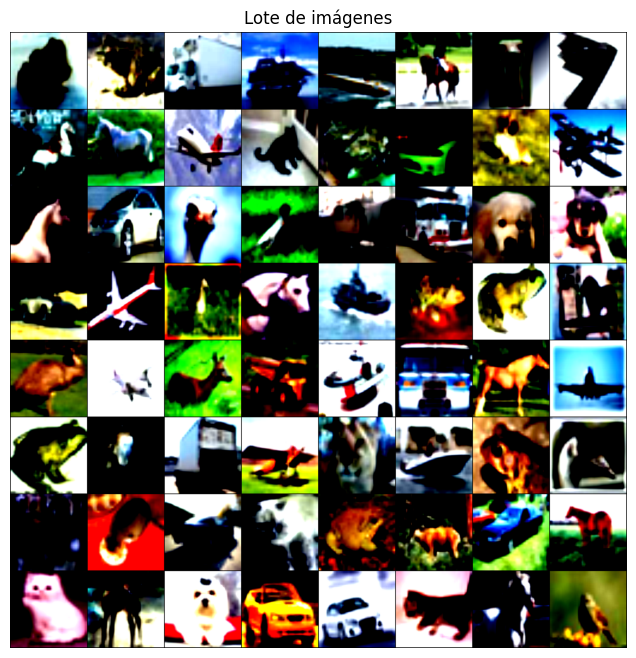

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

# Cargar el dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


data_lote,labels_lote=next(iter(train_loader))

grid = make_grid(data_lote, nrow=8, padding=2)

# Convertir la cuadrícula a formato visualizable
grid_np = grid.permute(1, 2, 0).numpy()

# Mostrar la cuadrícula
plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Lote de imágenes')
plt.show()

In [9]:
# Inicializar modelo, pérdida y optimizador
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

densnet121=DENSENET()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densnet121.parameters(), lr=0.0001)
epochs=20
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
modelo_entrenado,optimisador_entrenado=trainModel(densnet121,epochs,train_loader,test_loader,optimizer,scheduler,criterion)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Épocas:   0%|          | 0/20 [00:00<?, ?it/s]

Epoca 1 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 1, Pérdida: 1.5840, Precisión: 0.3419


Epoca 2 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 2, Pérdida: 1.2709, Precisión: 0.4171


Epoca 3 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 3, Pérdida: 1.1276, Precisión: 0.5128


Epoca 4 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 4, Pérdida: 1.0156, Precisión: 0.6100


Epoca 5 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 5, Pérdida: 0.9285, Precisión: 0.6738


Epoca 6 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 6, Pérdida: 0.8507, Precisión: 0.6703


Epoca 7 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 7, Pérdida: 0.7882, Precisión: 0.7069


Epoca 8 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 8, Pérdida: 0.7297, Precisión: 0.7219


Epoca 9 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 9, Pérdida: 0.6932, Precisión: 0.7442


Epoca 10 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 10, Pérdida: 0.6484, Precisión: 0.7568


Epoca 11 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 11, Pérdida: 0.6108, Precisión: 0.7529


Epoca 12 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 12, Pérdida: 0.5864, Precisión: 0.7670


Epoca 13 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 13, Pérdida: 0.5553, Precisión: 0.7635


Epoca 14 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 14, Pérdida: 0.5295, Precisión: 0.7836


Epoca 15 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 15, Pérdida: 0.5089, Precisión: 0.7824


Epoca 16 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 16, Pérdida: 0.4849, Precisión: 0.7868


Epoca 17 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 17, Pérdida: 0.4638, Precisión: 0.7982


Epoca 18 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 18, Pérdida: 0.4516, Precisión: 0.8046


Epoca 19 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 19, Pérdida: 0.4286, Precisión: 0.7887


Epoca 20 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 20, Pérdida: 0.4118, Precisión: 0.8118


Predicción: cat
Probabilidad: 0.5439


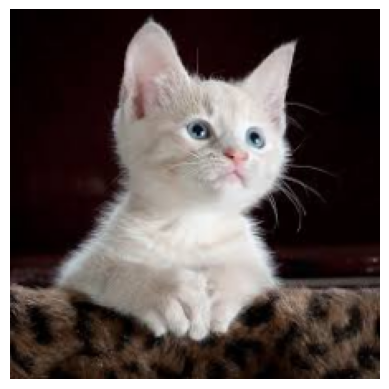

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

# Ruta de la imagen
file_path = "/content/images.jpg"  # @param {type:"string"}

# Cargar la imagen
img = Image.open(file_path)

# Transformaciones para la imagen: igual que durante el entrenamiento
transform = transforms.Compose([

    transforms.Resize((224, 224)),  # Redimensionar a 32x32
    transforms.ToTensor(),  # Convertir la imagen a tensor
])

# Aplicar las transformaciones

tensor_img= transform(img).unsqueeze(0)
tensor_img=tensor_img.to(device)
# Asegurarse de que el modelo esté en modo de evaluación
modelo_entrenado.eval()



# Hacer la predicción
with torch.no_grad():
    output = modelo_entrenado(tensor_img)

# Calcular las probabilidades con softmax
probabilities = F.softmax(output, dim=1)

# Obtener el índice de la clase con la mayor probabilidad
max_value, max_index = torch.max(probabilities, dim=1)

# Definir las clases (dígitos de 0 a 9)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Imprimir la predicción y la probabilidad
print(f'Predicción: {classes[max_index.item()]}')
print(f'Probabilidad: {max_value.item():.4f}')

tensor_img = tensor_img.squeeze(0)  # Eliminar la dimensión de batch, si es necesario

# Deshacer la normalización (si fue realizada previamente)



# Convertir de tensor a imagen PIL
to_pil = transforms.ToPILImage()
image = to_pil(tensor_img)
# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para solo mostrar la imagen
plt.show()


In [ ]:
#Guardar modelo y optimzador:

torch.save({
    'model_state_dict': modelo_entrenado.state_dict(),  # Guardar solo los pesos del modelo
    'optimizer_state_dict': optimisador_entrenado.state_dict()  # Guardar el estado del optimizador
}, 'DenseNet_checkpoint.pth')





In [ ]:


modelo = DENSENET().to(device)  # Asegúrate de definir la clase antes
optimizer = optim.Adam(modelo.parameters())  # Define el optimizador

# Cargar el checkpoint
checkpoint = torch.load('DenseNet_checkpoint.pth')

# Restaurar el estado del modelo y el optimizador
modelo.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

epochs=20
modelo_entrenado,optimisador_entrenado=trainModel(modelo,epochs,train_loader,test_loader,optimizer,scheduler,criterion)



<ipython-input-12-cbd3c15527de>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('GoogleNet_checkpoint.pth')
/usr/local/lib/python3.10/dist-packages/

Épocas:   0%|          | 0/20 [00:00<?, ?it/s]

Epoca 1 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 1, Pérdida: 0.5172, Precisión: 0.7747


Epoca 2 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 2, Pérdida: 0.5182, Precisión: 0.7728


Epoca 3 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 3, Pérdida: 0.5141, Precisión: 0.7739


Epoca 4 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 4, Pérdida: 0.5151, Precisión: 0.7764


Epoca 5 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 5, Pérdida: 0.5130, Precisión: 0.7734


Epoca 6 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 6, Pérdida: 0.5110, Precisión: 0.7726


Epoca 7 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 7, Pérdida: 0.5126, Precisión: 0.7703


Epoca 8 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 8, Pérdida: 0.5142, Precisión: 0.7732


Epoca 9 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 9, Pérdida: 0.5133, Precisión: 0.7778


Epoca 10 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 10, Pérdida: 0.5106, Precisión: 0.7753


Epoca 11 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 11, Pérdida: 0.5096, Precisión: 0.7725


Epoca 12 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 12, Pérdida: 0.5139, Precisión: 0.7743


Epoca 13 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 13, Pérdida: 0.5127, Precisión: 0.7753


Epoca 14 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 14, Pérdida: 0.5132, Precisión: 0.7692


Epoca 15 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 15, Pérdida: 0.5116, Precisión: 0.7739


Epoca 16 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 16, Pérdida: 0.5126, Precisión: 0.7749


Epoca 17 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 17, Pérdida: 0.5162, Precisión: 0.7746


Epoca 18 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 18, Pérdida: 0.5105, Precisión: 0.7752


Epoca 19 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 19, Pérdida: 0.5123, Precisión: 0.7716


Epoca 20 - Dataloader:   0%|          | 0/782 [00:00<?, ?batches/s]

Época 20, Pérdida: 0.5165, Precisión: 0.7769
